![](https://pbs.twimg.com/media/DiR9vbVX4AEhTFu.jpg)
# Machine Learning FINAL PROJECT
# Labelled Faces in the Wild
### Team members: Savoskin Roman, Biryukova Alexandra, Amambayeva Meruert
### Goal: Create a model that correctly identifies famous person on the photo and find images with high accuracy
### Dataset: LFW https://www.kaggle.com/jessicali9530/lfw-dataset

In [369]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
from PIL import Image
import keras
from sklearn.model_selection import train_test_split
import shutil
from shutil import unpack_archive
from subprocess import check_output
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
# image height, weight
TARGET_SIZE = (250, 250)

# Working with directories
In the work below we will also work with creation, removing and deleting the directories (in particular with working with train, validations and test datasets). Instead of code rewriting, we made a decision to create several function for future reusing

In [2]:
def create_dir(name, path=''):
    dirName = ''.join([path, name])
    try:
        os.makedirs(dirName)    
        print("Directory " , dirName ,  " Created ")
    except FileExistsError:
        print("Directory " , dirName ,  " already exists")

def del_dir(dir_path):
    import shutil
    try:
        shutil.rmtree(dir_path)
    except OSError as e:
        print("Error: %s : %s" % (dir_path, e.strerror))

# Working with dataset
We successfully downloaded dataset from the kaggle, and now we are interested in taking information about:
1. How many people are in the dataset?
2. How many images are in every person's folder?

All this information is already done for us in the special file name *lfg_allnames.csv*

In [3]:
# folder with all names and number of images, according to someone
all_names = pd.read_csv("./lfw-dataset/lfw_allnames.csv")
all_names.head()

,name,images
0,AJ_Cook,1
1,AJ_Lamas,1
2,Aaron_Eckhart,1
3,Aaron_Guiel,1
4,Aaron_Patterson,1


# Extract the data to work
Now our data is unstructured, let's take in one place and prepare data with that we will work
### Step 1: 
We are going to work with image paths without any folders, so we need to get all existed images. First of all we create as much images with default paths(which consist only of person's name) as there are in each folder. Ex:

If there are 4 images in Aaron_Pearsol folder, we will add following default paths to image_path:

1."Aaron_Pearsol" 

2."Aaron_Pearsol"

3."Aaron_Pearsol" 

4."Aaron_Pearsol"

### Step 2: 
All images in the folder of each person are numbered in increasing order (0001, 0002 etc), moreover, each image has name in the same format *"Folder_nameXXXX.jpg"* so we take that into account and use that nice structure and order to parse them to according paths

In [187]:
image_paths = all_names.loc[all_names.index.repeat(all_names['images'])]
image_paths["image_path"] = 1 + image_paths.groupby('name').cumcount()
image_paths["image_path"] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths["image_path"] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths.sample(10)

,name,images,image_path
2574,Jim_Beattie,1,Jim_Beattie/Jim_Beattie_0001.jpg
1020,Claudia_Coslovich,1,Claudia_Coslovich/Claudia_Coslovich_0001.jpg
620,Bobby_Goldwater,2,Bobby_Goldwater/Bobby_Goldwater_0002.jpg
2468,Jean_Chretien,55,Jean_Chretien/Jean_Chretien_0019.jpg
2647,Joe_Cravens,1,Joe_Cravens/Joe_Cravens_0001.jpg
1047,Colin_Powell,236,Colin_Powell/Colin_Powell_0190.jpg
941,Chris_Klein,1,Chris_Klein/Chris_Klein_0001.jpg
5458,Tony_Blair,144,Tony_Blair/Tony_Blair_0026.jpg
706,Britney_Spears,14,Britney_Spears/Britney_Spears_0012.jpg
2682,John_Ashcroft,53,John_Ashcroft/John_Ashcroft_0003.jpg


# Visualize and understand the data
### There're several factors in which we are interested: 
+ Standard deviation
+ Average (mean of images count)
+ Distribution according to % approach

### From these factors we understand that we have an extremely asymmetric distribution and may be it will be better to prepare data at first. We are disturbed by poor distribution because:
+ Our model can overfit on one persons, and underfit on others
+ It's less representative and can't really describe the real situation

##### To make sure that we won't spend a lot of time on training our model, we take only subset of people that we will classify and all with more that 50 pictures

In [214]:
df = pd.DataFrame(image_paths['name'].value_counts()).reset_index(drop=False)
df.columns = ['name', 'images_count']
print(df.describe())
df = df[df.images_count > 50]
df.tail()

       images_count
count   5749.000000
mean       2.301792
std        9.016410
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max      530.000000


,name,images_count
7,Junichiro_Koizumi,60
8,Jean_Chretien,55
9,John_Ashcroft,53
10,Jacques_Chirac,52
11,Serena_Williams,52


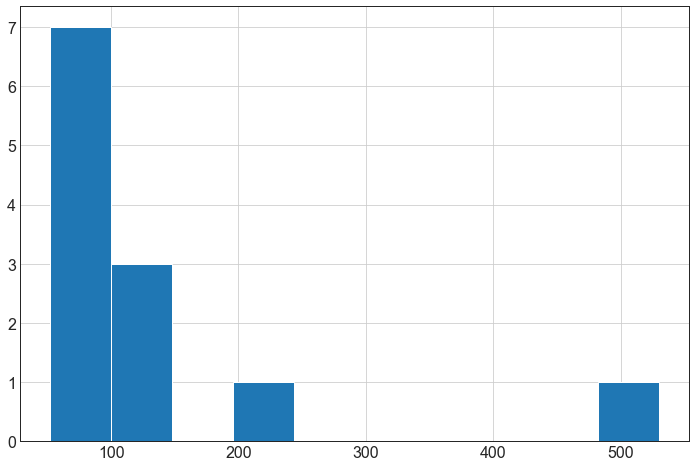

In [217]:
plt.figure(figsize=(12, 8))
df['images_count'].hist()

# Prepare the Data
### To make our data normally distributed was done the following:
+ Just divide data into equal samples, (Person A images) = (Person B images) = (Person C images) etc

##### It will be better if we split our datasets into different folders, for better work (train data - folder1, test data - folder2, validation data - folder 3), so we did it

In [218]:
# extract equal sized samples for each person; choose person in the set, identify min number of corresponding
# to some person images, choose as size for all other samples => sample all people
targets = pd.concat([image_paths[image_paths.name==name].sample(df['images_count'].min())\
                     for name in df['name'].unique()])
targets = targets.drop('images', 1)
targets.sample(10)

,name,image_path
2468,Jean_Chretien,Jean_Chretien/Jean_Chretien_0055.jpg
1404,Donald_Rumsfeld,Donald_Rumsfeld/Donald_Rumsfeld_0002.jpg
1404,Donald_Rumsfeld,Donald_Rumsfeld/Donald_Rumsfeld_0006.jpg
1871,George_W_Bush,George_W_Bush/George_W_Bush_0292.jpg
2175,Hugo_Chavez,Hugo_Chavez/Hugo_Chavez_0065.jpg
1892,Gerhard_Schroeder,Gerhard_Schroeder/Gerhard_Schroeder_0053.jpg
2175,Hugo_Chavez,Hugo_Chavez/Hugo_Chavez_0020.jpg
1892,Gerhard_Schroeder,Gerhard_Schroeder/Gerhard_Schroeder_0041.jpg
1404,Donald_Rumsfeld,Donald_Rumsfeld/Donald_Rumsfeld_0098.jpg
2175,Hugo_Chavez,Hugo_Chavez/Hugo_Chavez_0024.jpg


In [219]:
# as our data presented in the form dataframe, where name is Y and image from image_path (vector of the image)
# as X, then we can just instead of division to x_train, y_train, x_test, y_test etc
train, test = train_test_split(targets, test_size=0.20)
train, val = train_test_split(train, test_size=0.20)

In [221]:
def save_dataset(data,dir_name):
    """ 
    data - all images
    dir_name - path to store these images
    use user custom function 'create_dir()' to create
    folder with path and system os kernel functions
    to move files from one directory to another
    """
    pointer = 0
    for image in data.image_path:
        if not os.path.exists(os.path.join('main/',dir_name)):
            create_dir(os.path.join('main/',dir_name))
        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('main/',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('main/',dir_name,data_type))
        path_from = os.path.join('./lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/',image)
        path_to = os.path.join('main/',dir_name,data_type)
        shutil.copy(path_from, path_to)
        pointer = pointer + 1

In [222]:
save_dataset(train,"train/")
save_dataset(test,"test/")
save_dataset(val,"val/")

Directory  main/train/  Created 
Directory  main/test/  Created 
Directory  main/val/  Created 


# Build our model
### We write base model that we will improve in the future, for the start there was two models, the first model was very simple, the second was a bit complex and expected to be improved over our work

### Model architecture, version 1
+ Activation functions is relu
+ Input shape as three dimensional 250x250 size images
+ Dropout set to 0.5 means that we drop exactly half of our model weights at step, were we call dropout(make 0)

### Why RELU?
- computationally efficient
- better convergence (especially with comparing with sigmoid function)
<!-- ###### computationally efficient -->
<!-- ###### better convergence (especially with comparing with sigmoid function) -->

In [232]:
# model = Sequential()
# model.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))
# model.add(MaxPooling2D(pool_size = (2, 2)))
# model.add(Flatten())
# model.add(Dense(128, activation = 'relu'))
# model.add(Dense(len(df['name']), activation = 'softmax'))
# model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))  
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3),  activation='relu'))
model.add(Conv2D(64, (3, 3),activation='relu'))   
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu')) 
model.add(Conv2D(128, (3, 3), activation='relu')) 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Augmentation and preprocessing using ImageDataGenerator to boost the performance
+ Normalize the data by rescaling to rgb/255
+ Range for random zoom
+ Randomly flip inputs horizontally
+ Choose degree range for random rotations
+ Others doesn't affect on the model

#### *All perfect values for the variables were researched and found in the internet*

In [233]:
# data augmentation and normalization
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, shear_range = 0.2,\
                                                             zoom_range = 0.2, horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

## Good batch 
You cannot pass through a neural network all at once. Therefore, we divide the data into packages, sets or parties, just as a large article is divided into many sections - introduction, gradient descent, epochs, batch size and iteration. Such a breakdown makes it easier to read and understand the article. 

##### A larger batch size will give you a better gradient and will help to prevent jumping around
## But..
A batch_size that is too large can cause memory problems. As soon as we exceed the limit, we can dial it back until it works. This will help us to determine the maximum packet size that our system can handle. But..we weren't ready for such kind of experiments...

##### Too large packet size can lead to a freeze at local minimums, so if our training gets stuck, it will be better to reduce the batch size. I.e we overfit our jump and can't minimize the loss function

In [234]:
# we apply datagen function that takes the path to a directory and generates batches 
# of augmented/normalized data that was identified in the datagen
# class_mode can be binary, categorical, input, multi_output, raw, sparse or None
# "binary": 1D numpy array of binary labels,
# "categorical": 2D numpy array of one-hot encoded labels. Supports multi-label output.
# "input": images identical to input images (mainly used to work with autoencoders),
# "multi_output": list with the values of the different columns,
# "raw": numpy array of values in y_col column(s),
# "sparse": 1D numpy array of integer labels,
# None, no targets are returned (the generator will only yield batches of image data, 
#                                which is useful to use in model.predict_generator()).
training_set = train_datagen.flow_from_directory('main/train/',
                                                 target_size = TARGET_SIZE,
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 399 images belonging to 12 classes.


In [235]:
val_set = test_datagen.flow_from_directory('main/val/',
                                            target_size = TARGET_SIZE,
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 100 images belonging to 12 classes.


In [236]:
test_set = test_datagen.flow_from_directory('main/test/',
                                            target_size = TARGET_SIZE,
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 125 images belonging to 12 classes.


### Choosing parameters and fit_generator idea

Ideally we should use all validation data at once for the reason that if we use only part of our validation data, we will get different metrics for each batch, i.e our model can be better or much worst in real, than we think. So theoretically, if our batch size is a size of packet (set of data), then we suggest that validation_steps = total_val_sample // batch_size(validation set). Doing in that way we have the situation that all data passed exactly 1 time at each epoch, the same corresponds to the steps_per_epoch

### And what we had?
+ steps per epoch = len(train sample) / batch size(train sample)
+ validation steps = len(val sample) / batch size (validation sample)
+ at each epoch we should train exactly entire train and validate sets

##### fit generator just trains our model on data that generated batch by batch and all of that runs in parallel. 
# Don't run the following cell, it is for demonstration purposes, we are going to show how we work to improve model accuracy

In [237]:
history = model.fit_generator(training_set, steps_per_epoch = 13, epochs = 12,\
                              validation_data = val_set, validation_steps = 4)

Epoch 1/12
13/13 [==============================] - 109s 8s/step - loss: 2.5731 - accuracy: 0.0576 - val_loss: 2.5001 - val_accuracy: 0.0900
Epoch 2/12
13/13 [==============================] - 109s 8s/step - loss: 2.4763 - accuracy: 0.1378 - val_loss: 2.4176 - val_accuracy: 0.0900
Epoch 3/12
13/13 [==============================] - 107s 8s/step - loss: 2.4025 - accuracy: 0.1529 - val_loss: 2.3830 - val_accuracy: 0.2000
Epoch 4/12
13/13 [==============================] - 107s 8s/step - loss: 2.2118 - accuracy: 0.2431 - val_loss: 2.0591 - val_accuracy: 0.2700
Epoch 5/12
13/13 [==============================] - 108s 8s/step - loss: 1.9190 - accuracy: 0.3709 - val_loss: 1.4383 - val_accuracy: 0.3100
Epoch 6/12
13/13 [==============================] - 107s 8s/step - loss: 1.8650 - accuracy: 0.3759 - val_loss: 1.7149 - val_accuracy: 0.3500
Epoch 7/12
13/13 [==============================] - 109s 8s/step - loss: 1.7004 - accuracy: 0.4411 - val_loss: 2.2002 - val_accuracy: 0.4200
Epoch 8/12
13

From the results above and graphs below, we see that despite the fact that our train and validate accuracy are the same, but it's pronounced underfitting. The main problem, right now, can be in the Dropout part of our model that drop a lot of weights (half right now). We exclude dropout from the model, and if there also will problems with Dropout, we will se in the side of number of epochs

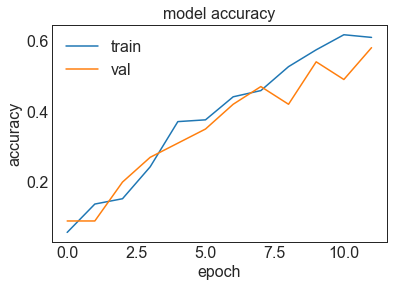

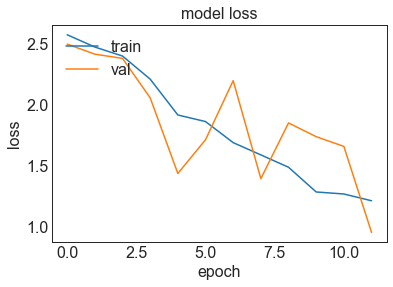

In [462]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
plot_history(history)

In [286]:
# second try 
model_v1 = Sequential()
model_v1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)))
model_v1.add(Conv2D(32, (3, 3), activation='relu'))  
model_v1.add(Conv2D(32, (3, 3), activation='relu')) 
model_v1.add(MaxPooling2D((2, 2)))
model_v1.add(Conv2D(64, (3, 3),  activation='relu'))
model_v1.add(Conv2D(64, (3, 3),activation='relu'))   
model_v1.add(MaxPooling2D((2, 2)))
model_v1.add(Conv2D(128, (3, 3), activation='relu')) 
model_v1.add(Conv2D(128, (3, 3), activation='relu')) 
model_v1.add(Flatten())
# model.add(Dropout())
model_v1.add(Dense(12,activation='softmax'))

model_v1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])



In [288]:
training_set_v1 = train_datagen.flow_from_directory('main/train/',
                                                 target_size = TARGET_SIZE,
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
val_set_v1 = test_datagen.flow_from_directory('main/val/',
                                            target_size = TARGET_SIZE,
                                            batch_size = 32,
                                            class_mode = 'categorical')
test_set_v1 = test_datagen.flow_from_directory('main/test/',
                                            target_size = TARGET_SIZE,
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 399 images belonging to 12 classes.
Found 100 images belonging to 12 classes.
Found 125 images belonging to 12 classes.


In [291]:
!pip install -q pyyaml h5py
import tensorflow as tf

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


# Don't run the following cell, it is for demonstration purposes, we are going to show how we work to improve model accuracy

In [293]:
checkpoint_path = "training_v1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# we create a callback for the model to save the weights during epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history_v1 = model_v1.fit_generator(training_set, steps_per_epoch = 13, epochs = 12,\
                              validation_data = val_set, validation_steps = 4)

Epoch 1/12
13/13 [==============================] - 111s 9s/step - loss: 2.5556 - accuracy: 0.1178 - val_loss: 2.4489 - val_accuracy: 0.1400
Epoch 2/12
13/13 [==============================] - 110s 8s/step - loss: 2.4418 - accuracy: 0.1178 - val_loss: 2.0686 - val_accuracy: 0.1200
Epoch 3/12
13/13 [==============================] - 109s 8s/step - loss: 2.2888 - accuracy: 0.1905 - val_loss: 2.5799 - val_accuracy: 0.2500
Epoch 4/12
13/13 [==============================] - 109s 8s/step - loss: 2.1144 - accuracy: 0.3158 - val_loss: 2.0491 - val_accuracy: 0.2800
Epoch 5/12
13/13 [==============================] - 109s 8s/step - loss: 1.8643 - accuracy: 0.3810 - val_loss: 1.4774 - val_accuracy: 0.3900
Epoch 6/12
13/13 [==============================] - 112s 9s/step - loss: 1.7053 - accuracy: 0.4486 - val_loss: 1.4883 - val_accuracy: 0.4100
Epoch 7/12
13/13 [==============================] - 116s 9s/step - loss: 1.4378 - accuracy: 0.5238 - val_loss: 0.8253 - val_accuracy: 0.4500
Epoch 8/12
13

Comparing with results of the previous model we see that our assumption was true, Dropout really affect on the train accuracy, however, this is definitely not the main reason. Let's see at the graph, and what we see? From the plots we see that our model isn't converging...There's can be several reasons, but.. Our training looks less or more stable, so we don't need to reduce our learning rate to prevent model from bouncing around in parameter space. But we can simplify the model and so we ensure that our model is better than some baseline model, and after that we can add some complexity

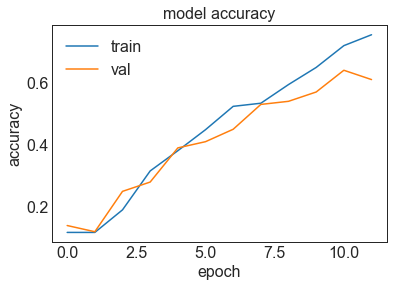

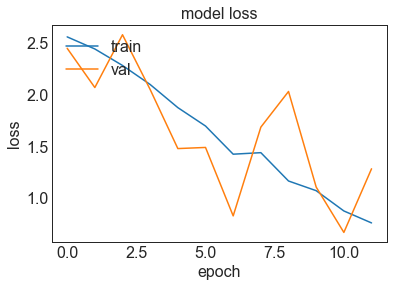

In [463]:
plot_history(history_v1)

In [319]:
# third try 
model_v2 = Sequential()
model_v2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)))
# model_v2.add(Conv2D(32, (3, 3), activation='relu'))  
# model_v2.add(Conv2D(32, (3, 3), activation='relu'))
model_v2.add(MaxPooling2D((2, 2)))
model_v2.add(Conv2D(64, (3, 3),  activation='relu'))
# model_v2.add(Conv2D(64, (3, 3),activation='relu'))
model_v2.add(MaxPooling2D((2, 2)))
model_v2.add(Conv2D(128, (3, 3), activation='relu')) 
# model_v2.add(Conv2D(128, (3, 3), activation='relu')) 
model_v2.add(Flatten())
# model.add(Dropout())
model_v2.add(Dense(12,activation='softmax'))

model_v2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [317]:
training_set_v2 = train_datagen.flow_from_directory('main/train/',
                                                 target_size = TARGET_SIZE,
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
val_set_v2 = test_datagen.flow_from_directory('main/val/',
                                            target_size = TARGET_SIZE,
                                            batch_size = 32,
                                            class_mode = 'categorical')
test_set_v2 = test_datagen.flow_from_directory('main/test/',
                                            target_size = TARGET_SIZE,
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 399 images belonging to 12 classes.
Found 100 images belonging to 12 classes.
Found 125 images belonging to 12 classes.


# Don't run the following cell, it is for demonstration purposes, we are going to show how we work to improve model accuracy

In [320]:
history_v2 = model_v2.fit_generator(training_set_v2, steps_per_epoch = 26, epochs = 15,\
                              validation_data = val_set_v2, validation_steps = 8)

Epoch 1/15
26/26 [==============================] - 59s 2s/step - loss: 2.6928 - accuracy: 0.1516 - val_loss: 2.4090 - val_accuracy: 0.2600
Epoch 2/15
26/26 [==============================] - 57s 2s/step - loss: 1.9433 - accuracy: 0.3358 - val_loss: 1.6195 - val_accuracy: 0.4300
Epoch 3/15
26/26 [==============================] - 57s 2s/step - loss: 1.4594 - accuracy: 0.5288 - val_loss: 1.1412 - val_accuracy: 0.4700
Epoch 4/15
26/26 [==============================] - 57s 2s/step - loss: 1.0171 - accuracy: 0.6842 - val_loss: 1.4855 - val_accuracy: 0.5500
Epoch 5/15
26/26 [==============================] - 58s 2s/step - loss: 0.8139 - accuracy: 0.7381 - val_loss: 2.1266 - val_accuracy: 0.6400
Epoch 6/15
26/26 [==============================] - 58s 2s/step - loss: 0.5477 - accuracy: 0.8208 - val_loss: 0.6271 - val_accuracy: 0.6700
Epoch 7/15
26/26 [==============================] - 59s 2s/step - loss: 0.4485 - accuracy: 0.8509 - val_loss: 3.2903 - val_accuracy: 0.6700
Epoch 8/15
26/26 [==

Exactly the third attempt and there's convergence, however, there is no reasons for joying. From the plot of losses we can see that our model is overfitted. What we can do in that case? Two main methods is to introduce dropout or regularization. We make our model less complex, but now, it's time to do it again. Also, it can be problems with division, our dataset can looks like very small and can't generalize. I.e small number of validation data in comparing with train data. 

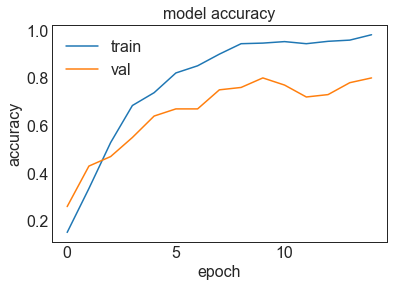

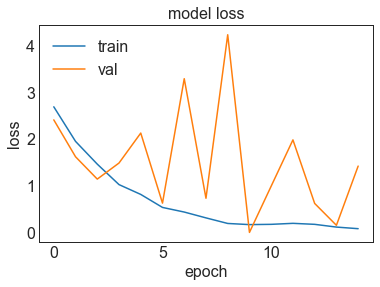

In [464]:
plot_history(history_v2)

In [503]:
train_v, test_v = train_test_split(targets, test_size=0.2)
train_v, val_v = train_test_split(train_v, test_size=0.2)
save_dataset(train_v,"train/")
save_dataset(test_v,"test/")
save_dataset(val_v,"val/")

Directory  main/train/  Created 
Directory  main/test/  Created 
Directory  main/val/  Created 


In [504]:
best_model = Sequential()
best_model.add(Conv2D(32, (3, 3), kernel_regularizer = regularizers.l2(0.01), activation='relu', input_shape=(250, 250, 3)))
best_model.add(MaxPooling2D((2, 2)))
best_model.add(Conv2D(64, (3, 3),kernel_regularizer = regularizers.l2(0.01),  activation='relu'))
best_model.add(MaxPooling2D((2, 2)))
best_model.add(Conv2D(128, (3, 3), kernel_regularizer = regularizers.l2(0.01),activation='relu')) 
best_model.add(Flatten())
best_model.add(Dropout(0.2))
best_model.add(Dense(128,activation='relu'))
best_model.add(Dense(12,activation='softmax'))
best_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy',precision,recall])


In [505]:
best_training_set = train_datagen.flow_from_directory('main/train/',
                                                 target_size = TARGET_SIZE,
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
best_val_set = test_datagen.flow_from_directory('main/val/',
                                            target_size = TARGET_SIZE,
                                            batch_size = 32,
                                            class_mode = 'categorical')
best_test_set = test_datagen.flow_from_directory('main/test/',
                                            target_size = TARGET_SIZE,
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 399 images belonging to 12 classes.
Found 100 images belonging to 12 classes.
Found 125 images belonging to 12 classes.


In [506]:
best_history = best_model.fit_generator(best_training_set, steps_per_epoch = 399, epochs = 2,\
                              validation_data = best_val_set, validation_steps = 100)

Epoch 1/2
399/399 [==============================] - 1424s 4s/step - loss: 1.3605 - accuracy: 0.7087 - precision: 0.7809 - recall: 0.6099 - val_loss: 2.2749 - val_accuracy: 0.7200 - val_precision: 0.7717 - val_recall: 0.6944
Epoch 2/2
399/399 [==============================] - 1340s 3s/step - loss: 0.3090 - accuracy: 0.9727 - precision: 0.9773 - recall: 0.9688 - val_loss: 2.7659 - val_accuracy: 0.7400 - val_precision: 0.7666 - val_recall: 0.7156


In [638]:
best_model.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_155 (Conv2D)          (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_156 (Conv2D)          (None, 122, 122, 64)      18496     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_157 (Conv2D)          (None, 59, 59, 128)       73856     
_________________________________________________________________
flatten_27 (Flatten)         (None, 445568)            0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 445568)          

In [484]:
from keras import optimizers

In [492]:
import keras.backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [368]:
from keras import backend as K
def l1_reg(weight_matrix):
    return 0.01 * K.sum(K.abs(weight_matrix))
from keras import regularizers

In [602]:
test_names = []
for i in range(len(best_test_set.filenames)):
    test_names.append(best_test_set.filenames[i])
for i in range(len(test_names)):
    test_names[i] = test_names[i].split("/")[0]
multi_test_name_order = list(OrderedDict.fromkeys(test_names))

In [603]:
multi_test_name_order

['Ariel_Sharon',
 'Colin_Powell',
 'Donald_Rumsfeld',
 'George_W_Bush',
 'Gerhard_Schroeder',
 'Hugo_Chavez',
 'Jacques_Chirac',
 'Jean_Chretien',
 'John_Ashcroft',
 'Junichiro_Koizumi',
 'Serena_Williams',
 'Tony_Blair']

In [604]:
def predict(dir_name,classifier,binary):
    predictions = []
    for im in os.listdir(dir_name):
        test_image = image.load_img(dir_name + str(im), target_size = (250,250))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        if(binary is True):
            result = float(str(classifier.predict(test_image))[2])
        else:
            result = np.argmax(classifier.predict(test_image))
        predictions.append(result)
    return(predictions)

Ariel_Sharon


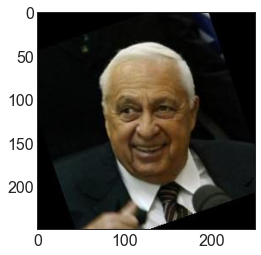

In [635]:
tested_image = image.load_img('./main/test/Ariel_Sharon/Ariel_Sharon_0041.jpg',target_size = (250,250))
plt.imshow(tested_image)
tested_image = image.img_to_array(tested_image)
tested_image = np.expand_dims(tested_image, axis=0)
print(multi_test_name_order[np.argmax(best_model.predict(tested_image))])

In [636]:
correct = []
predicted = []
for i in range(len(multi_test_name_order)):
    print(multi_test_name_order[i])
    array = predict("main/test/" + multi_test_name_order[i] + "/", best_model,binary=False)
    to_correct = [i for elem in array]
    correct.append(to_correct)
    predicted.append(array)

Ariel_Sharon
Colin_Powell
Donald_Rumsfeld
George_W_Bush
Gerhard_Schroeder
Hugo_Chavez
Jacques_Chirac
Jean_Chretien
John_Ashcroft
Junichiro_Koizumi
Serena_Williams
Tony_Blair


In [637]:
target_names =  multi_test_name_order

correct_flat = [item for sublist in correct for item in sublist]
predicted_flat = [item for sublist in predicted for item in sublist]

from sklearn.metrics import classification_report
print(classification_report(correct_flat, predicted_flat, target_names=target_names))


                   precision    recall  f1-score   support

     Ariel_Sharon       0.67      0.31      0.42        13
     Colin_Powell       0.50      0.83      0.62        12
  Donald_Rumsfeld       0.58      0.70      0.64        10
    George_W_Bush       0.83      0.56      0.67         9
Gerhard_Schroeder       0.86      0.40      0.55        15
      Hugo_Chavez       0.60      0.38      0.46         8
   Jacques_Chirac       0.35      0.67      0.46         9
    Jean_Chretien       0.77      0.62      0.69        16
    John_Ashcroft       0.31      1.00      0.47         4
Junichiro_Koizumi       0.73      1.00      0.84         8
  Serena_Williams       1.00      0.82      0.90        11
       Tony_Blair       0.67      0.40      0.50        10

         accuracy                           0.61       125
        macro avg       0.66      0.64      0.60       125
     weighted avg       0.69      0.61      0.61       125

